In [1]:
import torch
import numpy as np
import cv2
import scipy

# from torch import nn
from PIL import Image, ImageOps
import matplotlib.pyplot as plt


from numpy import dot
from numpy.linalg import matrix_rank, inv
from numpy.random import permutation
from scipy.linalg import eigh
from scipy.linalg import norm as mnorm
from scipy.stats import ortho_group

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

import os


import ica


import sys
sys.path.append('/data/users2/yxiao11/model/ICA')
from modules.util import entropyLoss, getdata, infomaxICA, entropy
# from modules.kde import kernel_density_estimator
# import n_sphere



In [2]:
file_name = os.listdir('/data/users2/yxiao11/model/ICA/data')
dir_list = []
for name in file_name[0:5]:
    dir_list.append('/data/users2/yxiao11/model/ICA/data/'+name)
num_of_img = len(dir_list)
# num_of_img = 3
resize = 128

array_list=[]

for img_dir in dir_list:
    image = Image.open(img_dir)
    image = np.array(ImageOps.grayscale(image))
    image = cv2.resize(image, (resize, resize))
#     image = torch.from_numpy(image).float().flatten()
    image = np.expand_dims(image.flatten(), axis=0)
    array_list.append(image)

img_concate = np.concatenate(array_list)
np.random.seed(1)

# D = np.diag(2**np.array([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7], dtype=float))

# B = ortho_group.rvs(dim=num_of_img)
# A = B @ D
# A = np.random.normal(0, 1, size=(num_of_img,num_of_img))
A = np.random.rand(num_of_img,num_of_img)
mixture = A@img_concate

print(A, img_concate.shape, sep='\n')

print('condition number:', np.linalg.cond(A))


[[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01
  1.46755891e-01]
 [9.23385948e-02 1.86260211e-01 3.45560727e-01 3.96767474e-01
  5.38816734e-01]
 [4.19194514e-01 6.85219500e-01 2.04452250e-01 8.78117436e-01
  2.73875932e-02]
 [6.70467510e-01 4.17304802e-01 5.58689828e-01 1.40386939e-01
  1.98101489e-01]
 [8.00744569e-01 9.68261576e-01 3.13424178e-01 6.92322616e-01
  8.76389152e-01]]
(5, 16384)
condition number: 23.66792577690414


# plot of ica.ica1 output

In [3]:
# A0, r, W = ica.ica1(mixture, num_of_img, verbose=True)
# # print(w)


# plt.figure(figsize=(10,10))

# sub_shape = num_of_img

# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(r[i], r[j], '.', ms=0.1)


# %matplotlib inline

# plt.figure(figsize=(10,10))
# for i in range(num_of_img):
#     plt.subplot(num_of_img, 2, i*2+1)
#     plt.imshow(np.reshape(mixture[i], (resize,resize)), cmap='gray')
#     plt.title('mixture')
#     plt.axis('off')
    
#     plt.subplot(num_of_img, 2, i*2+2)
#     plt.imshow(np.reshape(r[i], (resize,resize)), cmap='gray')
#     plt.title('output')
#     plt.axis('off')

In [4]:
#data whitening
# minim = np.expand_dims(np.min(mixture, axis=1),1)
# maxim = np.expand_dims(np.max(mixture, axis=1),1)
# mixture = (mixture-minim)/(maxim-minim)


# IPT = x_white.copy()
# IPT = torch.from_numpy(IPT).type(torch.float32)
# IPT = torch.from_numpy(mixture).type(torch.float32)
# IPT = (IPT - IPT.mean(axis=1).unsqueeze(1))/(IPT.std(axis=1, unbiased=False).unsqueeze(1))

# IPT_white = IPT.clone()

x_white, white, dewhite = ica.pca_whiten(mixture, num_of_img)

IPT = torch.from_numpy(x_white.copy()).type(torch.float32)

# minim = torch.min(IPT, axis=1)[0].unsqueeze(1)
# maxim = torch.max(IPT, axis=1)[0].unsqueeze(1)
# IPT = (IPT-minim)/(maxim-minim)

In [5]:
# %matplotlib inline
# plt.figure(figsize=(20,20))

# index = num_of_img

# for row in range(index):
#     for column in range(index):
#         plt.subplot(index, index, row*index + column+1)
#         plt.plot(x_white[row], x_white[column], '.', ms=0.5)

In [6]:
# %matplotlib inline
# plt.figure(figsize=(20,20))

# index = num_of_img

# for row in range(index):
#     for column in range(index):
#         plt.subplot(index, index, row*index + column+1)
#         plt.plot(x_white[row], x_white[column], '.', ms=0.5)

In [7]:
device = torch.device('cuda:0')

In [8]:
model = infomaxICA(num_of_img)

In [9]:
learning_rate = 0.1 / np.log(num_of_img)
# learning_rate = 0.0001
batch_size = int(np.floor(np.sqrt(IPT.shape[1] / 3)))
# batch_size = int(resize*resize)
# batch_size = 1024
dataset = getdata(IPT)
sampler = SequentialSampler(dataset)
# sampler = RandomSampler(dataset)
loader = DataLoader(dataset=dataset, sampler=sampler, batch_size=batch_size, num_workers=3)

# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=learning_rate,
                             eps=10e-4,
                             weight_decay = 1e-4,
                            )


num_epoch = 100
# scheduler = CosineAnnealingLR(optimizer, T_max = num_epoch/2)
scheduler = OneCycleLR(optimizer, 
                       learning_rate, 
                       steps_per_epoch=len(loader), 
                       epochs=num_epoch,
                      )

# np.linalg.inv(model.W1.weight.data)

In [10]:
def infonce(opt, ipt_batch, t=100):
    
    _, d = opt.shape
    
    f = torch.exp(torch.norm(ipt_batch.T@opt, dim=0)/t)
    Ln = 0
    for i in range(d):
        index = [x for x in range(d) if x!=i]
        denominator = f[index].sum() + 1e-12

        numerator = f[i]
        Ln += torch.log(numerator/denominator)
    return Ln

In [11]:
model = model.to(device)
IPT = IPT.to(device)

In [12]:
loss_tracker = []

In [13]:
def norm(x):
    """Computes the norm of a vector or the Frobenius norm of a
    matrix_rank
    """
    return torch.norm(torch.flatten(x))

<IPython.core.display.Javascript object>


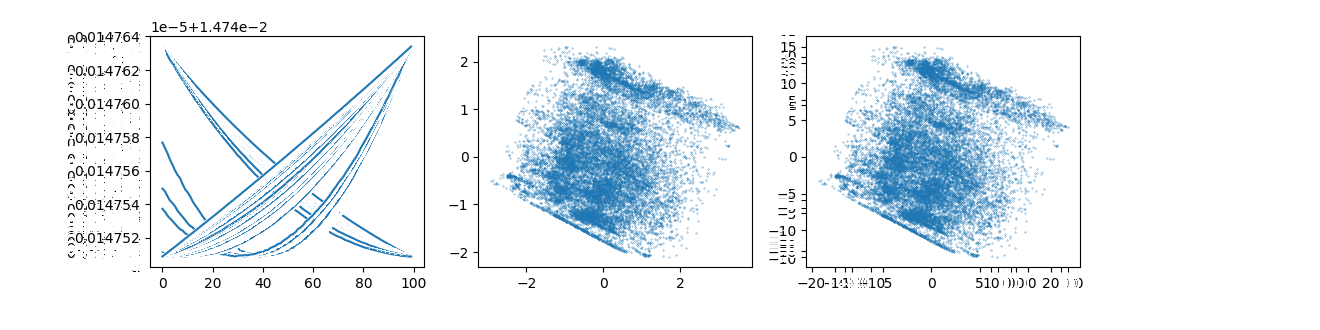

lr changed to: 0.05592014411036507
1 tensor(90.) 0.028633050620555878 tensor(0.8005, device='cuda:0')
2 tensor(47.3629) 0.02222117967903614 tensor(0.1007, device='cuda:0')
lr changed to: 0.050328129699328567
3 tensor(68.2556) 0.02123933844268322 tensor(0.0312, device='cuda:0')
4 tensor(28.6356) 0.02091735228896141 tensor(0.0256, device='cuda:0')
5 tensor(42.8634) 0.020633503794670105 tensor(0.0236, device='cuda:0')
6 tensor(51.5514) 0.02037092112004757 tensor(0.0213, device='cuda:0')
7 tensor(58.0751) 0.02010532096028328 tensor(0.0207, device='cuda:0')
lr changed to: 0.04529531672939571
8 tensor(63.2734) 0.019821057096123695 tensor(0.0215, device='cuda:0')
9 tensor(8.2016) 0.01950274035334587 tensor(0.0231, device='cuda:0')
10 tensor(16.3648) 0.019147859886288643 tensor(0.0246, device='cuda:0')
11 tensor(24.6079) 0.018782204017043114 tensor(0.0246, device='cuda:0')
12 tensor(33.0194) 0.01844613254070282 tensor(0.0221, device='cuda:0')
13 tensor(41.7530) 0.01816496066749096 tensor(0.018

113 tensor(52.3604) 0.014907444827258587 tensor(0.0002, device='cuda:0')
114 tensor(52.3592) 0.014905933290719986 tensor(0.0002, device='cuda:0')
115 tensor(52.3641) 0.014904436655342579 tensor(0.0002, device='cuda:0')
116 tensor(52.3616) 0.014902960509061813 tensor(0.0002, device='cuda:0')
117 tensor(52.3638) 0.014901496469974518 tensor(0.0002, device='cuda:0')
118 tensor(52.3647) 0.014900037087500095 tensor(0.0002, device='cuda:0')
119 tensor(52.3663) 0.014898606576025486 tensor(0.0002, device='cuda:0')
120 tensor(52.3663) 0.014897184446454048 tensor(0.0002, device='cuda:0')
121 tensor(52.3674) 0.014895780943334103 tensor(0.0002, device='cuda:0')
122 tensor(52.3679) 0.014894380234181881 tensor(0.0002, device='cuda:0')
123 tensor(52.3692) 0.014892998151481152 tensor(0.0002, device='cuda:0')
124 tensor(52.3689) 0.014891626313328743 tensor(0.0002, device='cuda:0')
125 tensor(52.3707) 0.014890271238982677 tensor(0.0002, device='cuda:0')
126 tensor(52.3701) 0.01488893385976553 tensor(0.00

226 tensor(52.3552) 0.014799097552895546 tensor(0.0001, device='cuda:0')
227 tensor(52.3572) 0.014798508025705814 tensor(0.0001, device='cuda:0')
228 tensor(52.3564) 0.014797922223806381 tensor(0.0001, device='cuda:0')
229 tensor(52.3604) 0.01479734294116497 tensor(0.0001, device='cuda:0')
230 tensor(52.3568) 0.014796767383813858 tensor(0.0001, device='cuda:0')
231 tensor(52.3580) 0.014796190895140171 tensor(0.0001, device='cuda:0')
232 tensor(52.3518) 0.014795629307627678 tensor(0.0001, device='cuda:0')
233 tensor(52.3531) 0.014795065857470036 tensor(0.0001, device='cuda:0')
234 tensor(52.3544) 0.014794503338634968 tensor(0.0001, device='cuda:0')
235 tensor(52.3494) 0.014793949201703072 tensor(0.0001, device='cuda:0')
236 tensor(52.3517) 0.014793395064771175 tensor(0.0001, device='cuda:0')
237 tensor(52.3534) 0.014792857691645622 tensor(0.0001, device='cuda:0')
238 tensor(52.3550) 0.014792307280004025 tensor(0.0001, device='cuda:0')
239 tensor(52.3504) 0.014791772700846195 tensor(0.00

339 tensor(52.3049) 0.014753496274352074 tensor(0.0001, device='cuda:0')
340 tensor(52.3085) 0.014753232710063457 tensor(0.0001, device='cuda:0')
341 tensor(52.3128) 0.014752975665032864 tensor(0.0001, device='cuda:0')
342 tensor(52.3062) 0.014752726070582867 tensor(0.0001, device='cuda:0')
343 tensor(52.3030) 0.014752471819519997 tensor(0.0001, device='cuda:0')
344 tensor(52.3037) 0.014752215705811977 tensor(0.0001, device='cuda:0')
345 tensor(52.3104) 0.014751970767974854 tensor(0.0001, device='cuda:0')
346 tensor(52.3043) 0.014751717448234558 tensor(0.0001, device='cuda:0')
347 tensor(52.3056) 0.014751475304365158 tensor(0.0001, device='cuda:0')
348 tensor(52.3074) 0.014751226641237736 tensor(0.0001, device='cuda:0')
349 tensor(52.3079) 0.014750988222658634 tensor(0.0001, device='cuda:0')
350 tensor(52.3031) 0.014750749804079533 tensor(0.0001, device='cuda:0')
351 tensor(52.3045) 0.014750503934919834 tensor(0.0001, device='cuda:0')
352 tensor(52.3001) 0.01475027110427618 tensor(0.00

448 tensor(52.2825) 0.014734582975506783 tensor(9.4794e-05, device='cuda:0')
513 tensor(52.2809) 0.014729980379343033 tensor(9.3068e-05, device='cuda:0')
514 tensor(52.2899) 0.014729936607182026 tensor(9.3065e-05, device='cuda:0')
515 tensor(52.2863) 0.014729899354279041 tensor(9.3046e-05, device='cuda:0')
516 tensor(52.2877) 0.014729851856827736 tensor(9.3038e-05, device='cuda:0')
517 tensor(52.2808) 0.014729812741279602 tensor(9.3024e-05, device='cuda:0')
518 tensor(52.2877) 0.014729777351021767 tensor(9.3016e-05, device='cuda:0')
519 tensor(52.2826) 0.014729739166796207 tensor(9.2986e-05, device='cuda:0')
520 tensor(52.2862) 0.014729702845215797 tensor(9.3001e-05, device='cuda:0')
521 tensor(52.2851) 0.014729664660990238 tensor(9.2962e-05, device='cuda:0')
522 tensor(52.2857) 0.014729630202054977 tensor(9.2992e-05, device='cuda:0')
523 tensor(52.2882) 0.014729591086506844 tensor(9.2969e-05, device='cuda:0')
524 tensor(52.2841) 0.014729559421539307 tensor(9.2967e-05, device='cuda:0')

619 tensor(52.3126) 0.014729303307831287 tensor(9.3604e-05, device='cuda:0')
620 tensor(52.3144) 0.014729328453540802 tensor(9.3626e-05, device='cuda:0')
621 tensor(52.3110) 0.014729350805282593 tensor(9.3661e-05, device='cuda:0')
622 tensor(52.3184) 0.014729377813637257 tensor(9.3683e-05, device='cuda:0')
623 tensor(52.3154) 0.014729410409927368 tensor(9.3713e-05, device='cuda:0')
624 tensor(52.3125) 0.014729436486959457 tensor(9.3746e-05, device='cuda:0')
625 tensor(52.3137) 0.014729464426636696 tensor(9.3763e-05, device='cuda:0')
626 tensor(52.3137) 0.014729492366313934 tensor(9.3782e-05, device='cuda:0')
627 tensor(52.3126) 0.014729523099958897 tensor(9.3765e-05, device='cuda:0')
628 tensor(52.3221) 0.014729546383023262 tensor(9.3830e-05, device='cuda:0')
629 tensor(52.3246) 0.014729578047990799 tensor(9.3825e-05, device='cuda:0')
630 tensor(52.3201) 0.014729609712958336 tensor(9.3840e-05, device='cuda:0')
631 tensor(52.3199) 0.014729637652635574 tensor(9.3874e-05, device='cuda:0')

726 tensor(52.3706) 0.014734477736055851 tensor(9.6132e-05, device='cuda:0')
727 tensor(52.3782) 0.014734547585248947 tensor(9.6154e-05, device='cuda:0')
728 tensor(52.3820) 0.014734616503119469 tensor(9.6194e-05, device='cuda:0')
729 tensor(52.3807) 0.01473468542098999 tensor(9.6234e-05, device='cuda:0')
730 tensor(52.3807) 0.014734754338860512 tensor(9.6295e-05, device='cuda:0')
731 tensor(52.3808) 0.014734825119376183 tensor(9.6304e-05, device='cuda:0')
732 tensor(52.3803) 0.014734894968569279 tensor(9.6301e-05, device='cuda:0')
733 tensor(52.3814) 0.014734969474375248 tensor(9.6309e-05, device='cuda:0')
734 tensor(52.3849) 0.01473503839224577 tensor(9.6347e-05, device='cuda:0')
735 tensor(52.3871) 0.014735111966729164 tensor(9.6417e-05, device='cuda:0')
736 tensor(52.3819) 0.014735182747244835 tensor(9.6429e-05, device='cuda:0')
737 tensor(52.3849) 0.014735260047018528 tensor(9.6408e-05, device='cuda:0')
738 tensor(52.3867) 0.014735326170921326 tensor(9.6465e-05, device='cuda:0')
7

833 tensor(52.4692) 0.014743631705641747 tensor(9.8617e-05, device='cuda:0')
834 tensor(52.4757) 0.014743732288479805 tensor(9.8531e-05, device='cuda:0')
835 tensor(52.4763) 0.01474383007735014 tensor(9.8563e-05, device='cuda:0')
836 tensor(52.4693) 0.014743931591510773 tensor(9.8618e-05, device='cuda:0')
837 tensor(52.4776) 0.01474403589963913 tensor(9.8644e-05, device='cuda:0')
838 tensor(52.4733) 0.01474413089454174 tensor(9.8593e-05, device='cuda:0')
839 tensor(52.4767) 0.014744235202670097 tensor(9.8661e-05, device='cuda:0')
840 tensor(52.4676) 0.014744339510798454 tensor(9.8639e-05, device='cuda:0')
841 tensor(52.4775) 0.014744441024959087 tensor(9.8673e-05, device='cuda:0')
842 tensor(52.4883) 0.014744543470442295 tensor(9.8717e-05, device='cuda:0')
843 tensor(52.4878) 0.014744643121957779 tensor(9.8705e-05, device='cuda:0')
844 tensor(52.4826) 0.01474475022405386 tensor(9.8715e-05, device='cuda:0')
845 tensor(52.4757) 0.014744854532182217 tensor(9.8711e-05, device='cuda:0')
846

940 tensor(52.6019) 0.014755701646208763 tensor(9.9303e-05, device='cuda:0')
941 tensor(52.5810) 0.014755834825336933 tensor(9.9197e-05, device='cuda:0')
942 tensor(52.5950) 0.014755958691239357 tensor(9.9295e-05, device='cuda:0')
943 tensor(52.5968) 0.014756078831851482 tensor(9.9278e-05, device='cuda:0')
944 tensor(52.5911) 0.014756206423044205 tensor(9.9210e-05, device='cuda:0')
945 tensor(52.6016) 0.014756333082914352 tensor(9.9219e-05, device='cuda:0')
946 tensor(52.5958) 0.014756458811461926 tensor(9.9197e-05, device='cuda:0')
947 tensor(52.5853) 0.014756583608686924 tensor(9.9138e-05, device='cuda:0')
948 tensor(52.5971) 0.014756706543266773 tensor(9.9157e-05, device='cuda:0')
949 tensor(52.6082) 0.014756831340491772 tensor(9.9204e-05, device='cuda:0')
950 tensor(52.6036) 0.014756965450942516 tensor(9.9171e-05, device='cuda:0')
951 tensor(52.6117) 0.014757092110812664 tensor(9.9222e-05, device='cuda:0')
952 tensor(52.6119) 0.014757214114069939 tensor(9.9173e-05, device='cuda:0')

In [14]:
%matplotlib notebook

k = int(batch_size*0.16)

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
# ax2 = fig.add_subplot(133, projection='3d')
ax3 = fig.add_subplot(133)

# trace = []
change = 100
W_STOP = 1e-10
d_weigths = torch.zeros(num_of_img)
old_d_weights = torch.zeros([1, num_of_img])
torch_pi = torch.acos(torch.zeros(1)).item() * 2 

# for epoch in range(num_epoch):
step0 = 0
angle_delta = 0
# while step0 < num_epoch and change > W_STOP:
for i in range(1000):
    LOSS = 0
    old_weight = torch.clone(model.W1.weight.data)
    for step, ipt in enumerate(loader):
        model.zero_grad()
        ipt = ipt.to(device)
        
        opt = model.forward(ipt)

#         loss = entropyLoss(opt.permute(1,0), device=device)
#         loss = entropy(opt, k=k, dis=1)
        loss = (torch.tril(torch.corrcoef(opt.permute(1,0)),diagonal=-1)**2).sum()
        loss.backward()
        optimizer.step()
        LOSS+=loss
    d_weigths = model.W1.weight.data - old_weight
    change = norm(d_weigths)**2
    d_weigths = d_weigths.cpu()
    if step > 2:
        angle_delta = torch.arccos(
                    torch.sum(d_weigths * old_d_weights) /
                    (norm(d_weigths) * norm(old_d_weights) + 1e-8)
                ) * 180 / torch_pi
    if angle_delta > 60:
        learning_rate = learning_rate * 0.9
        
        print('lr changed to:', learning_rate)
        
        optimizer.param_groups[0]['lr'] = learning_rate
        old_d_weights = torch.clone(d_weigths)
    elif step == 1:
        old_d_weights = torch.clone(d_weigths)
        
        
        
    LOSS = LOSS.cpu()
    loss_tracker.append(LOSS.detach().numpy()/len(loader.sampler))
    if step0 % 2 == 0:
        
#         index = np.random.randint(0,num_of_img, 2)
        index = [0,1]
        ax.clear()
        ax.plot(loss_tracker[-100:])
        fig.canvas.draw()
    
#         data = model.forward(IPT.T).cpu().detach().numpy()
        data1 = model.forward(IPT.T)
#         data2 = angle2cart(data1).cpu().detach().numpy()
#         data2 = spher2cart(data1).cpu().detach().numpy()
        data1 = data1.cpu().detach().numpy()
        data = (IPT.T@model.W1.weight.data.T).cpu().detach().numpy()
#         data2 = data.cpu().detach().numpy()
        ax1.clear()
        ax1.plot(data1[:, index[0]], data1[:, index[1]], '.', ms=0.5)
        fig.canvas.draw()
        
#         ax2.clear()
#         ax2.scatter(data2[:,-1], data2[:,-2], data2[:,-3], c = 'r', s=0.1)

# #         ax2.set_xlim3d(-2,2)
# #         ax2.set_ylim3d(-2,2)
# #         ax2.set_zlim3d(-2,2)
#         ax2.set_xlim3d(-10,10)
#         ax2.set_ylim3d(-10,10)
#         ax2.set_zlim3d(-10,10)
        
#         fig.canvas.draw()

        ax3.clear()
        
        ax3.plot(data[:, index[0]], data[:, index[1]], '.', ms=0.5)
        fig.canvas.draw()
        

    

    step0 += 1
    print(step0, angle_delta, LOSS.detach().numpy()/len(loader.sampler), change)
    scheduler.step()

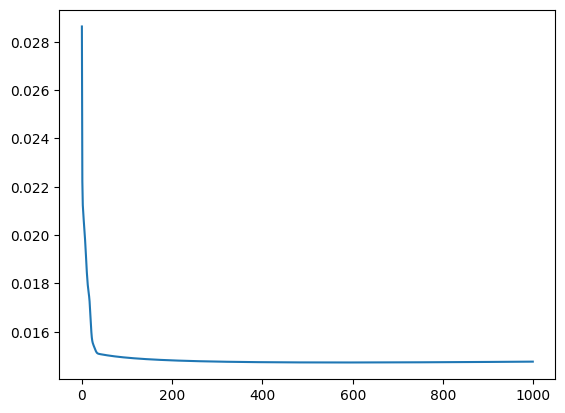

In [15]:
%matplotlib inline
plt.plot(loss_tracker)

In [16]:
# %matplotlib notebook
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# # Data for a three-dimensional line
# zline = data2[:, -1]
# xline = data2[:, -2]
# yline = data2[:, -3]

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-10,10)
# ax.set_zlim3d(-10,10)

# ax.scatter(xline, yline, zline, c = 'r', s=0.1)

In [17]:
# %matplotlib inline

# plt.plot(data2[:,0], data2[:,1], '.', ms=0.5)
# plt.axis('square')

In [18]:
# nn_rescale_opt = data.copy()

# nn_rescale_opt[nn_rescale_opt>np.pi] -= np.pi
# nn_rescale_opt[nn_rescale_opt<-np.pi] += np.pi

# nn_rescale_opt[nn_rescale_opt>np.pi] -= 2*np.pi
# nn_rescale_opt[nn_rescale_opt<-np.pi] += 2*np.pi

# %matplotlib inline
# plt.plot(nn_rescale_opt[:,0], nn_rescale_opt[:,1], '.', ms=0.5)
# plt.axis('square')

In [19]:
# %matplotlib notebook
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# # Data for a three-dimensional line
# zline = data2[:, -1]
# xline = data2[:, -2]
# yline = data2[:, -3]
# ax.scatter(xline, yline, zline, c = 'r', s=0.1)

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-10,10)
# ax.set_zlim3d(-10,10)

# plt.axis('auto')

In [20]:
# # generate uniform dense torus for compare

# rand_val = torch.randn(4096, num_of_img) 
# A = torch.tanh(rand_val)*np.pi*2
# P = angle2cart(A)

# %matplotlib notebook
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# # Data for a three-dimensional line
# zline = P[:, -1]
# xline = P[:, -2]
# yline = P[:, -3]
# ax.scatter(xline, yline, zline, c = 'r', s=0.1)

# ax.set_xlim3d(-10,10)
# ax.set_ylim3d(-10,10)
# ax.set_zlim3d(-10,10)

In [21]:
# opt = model.forward(IPT.T).cpu()
# opt = angle2cart(opt)

# print('the eutropy of uniform:', entropy(P, k=3))
# print('the entropy of angle to cart:', entropy(opt, k=3))

In [22]:
# model = model.cpu()
# IPT = IPT.cpu()
# data = (IPT.T@model.W1.weight.data.T).cpu().detach().numpy()

In [23]:
# data = (IPT.T@model.W1.weight.data.T).cpu().detach().numpy()
# data = model.forward(IPT.T).cpu().detach().numpy()


In [24]:
# %matplotlib inline
# # plt.plot(data[:,0], data[:,1], '.', ms=0.5)
# # # plt.axis('square')
# plt.figure(figsize=(10,10))
# sub_shape = num_of_img
# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(data[:, i], data[:, j], '.', ms=1)
#         plt.axis('square')

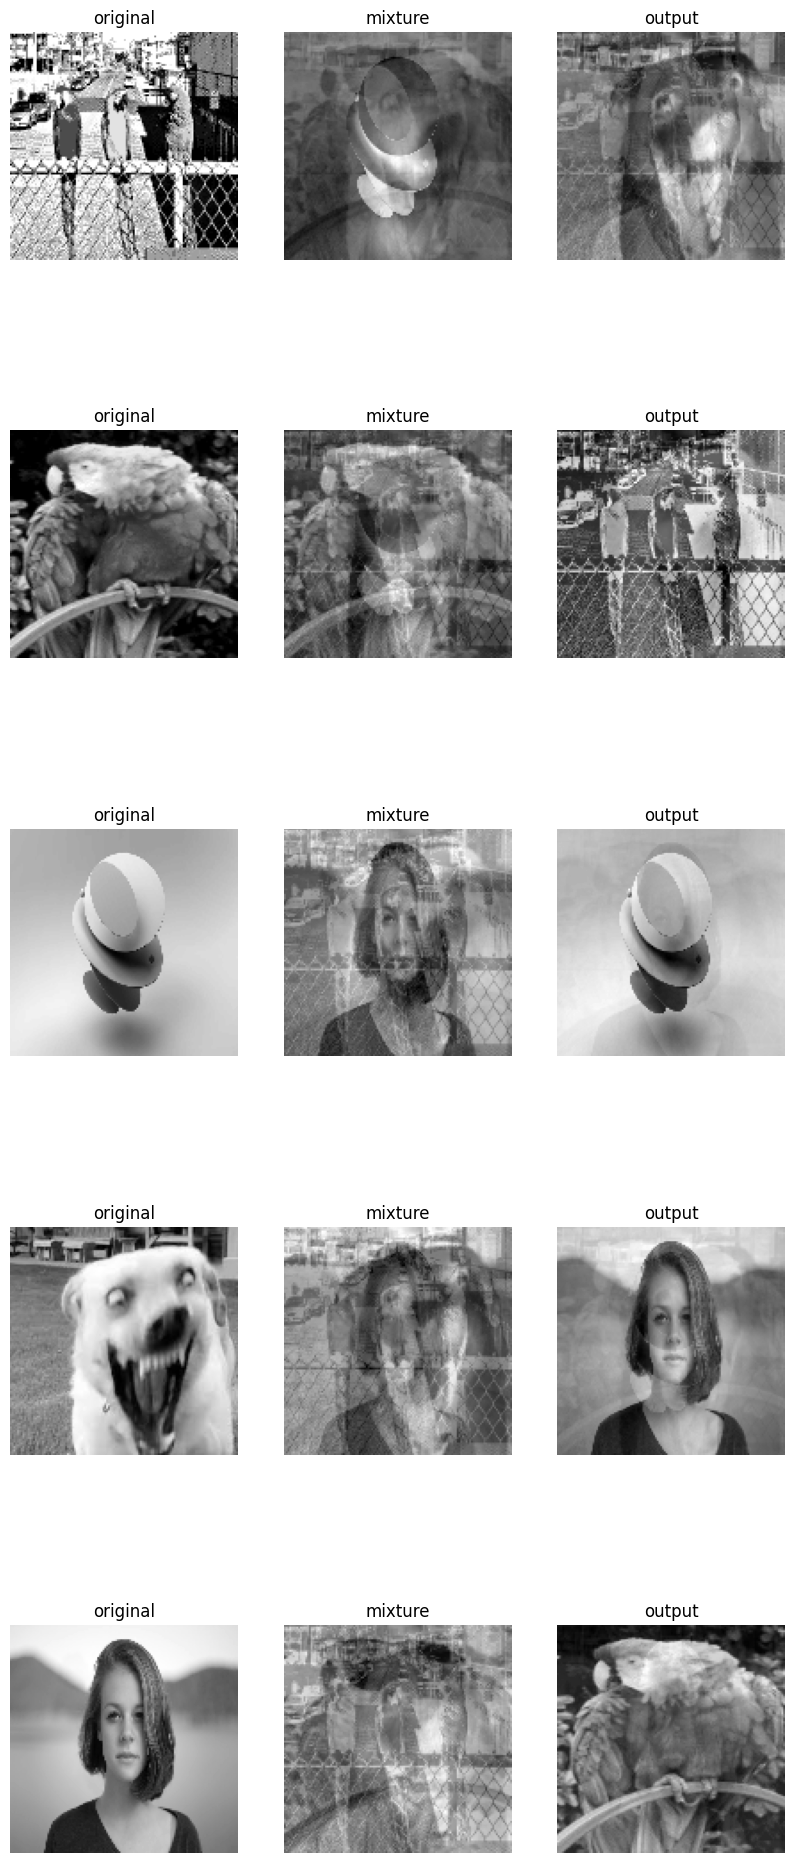

In [25]:
%matplotlib inline

plt.figure(figsize=(10,5*num_of_img))
for i in range(num_of_img):
    plt.subplot(num_of_img, 3, i*3+1)
    plt.imshow(np.reshape(array_list[i], (resize,resize)), cmap='gray')
    plt.title('original')
    plt.axis('off')
    
    plt.subplot(num_of_img, 3, i*3+2)
    plt.imshow(np.reshape(x_white[i], (resize,resize)), cmap='gray')
    plt.title('mixture')
    plt.axis('off')
    
    plt.subplot(num_of_img, 3, i*3+3)
    plt.imshow(np.reshape(data[:, i], (resize,resize)), cmap='gray')
    plt.title('output')
    plt.axis('off')

In [26]:
# for i in range(sub_shape):
#     for j in range(sub_shape):
#         plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
#         plt.plot(data2.T[:, i], data2.T[:, j], '.', ms=1)
#         plt.axis('square')

In [27]:
# def myISI(WAr):
#     N = WAr.shape[0]
#     WAr = np.abs(WAr)
#     ISI = 0.
#     ISI += np.sum(np.sum(WAr,axis=1)/np.max(WAr,axis=1) - 1)
#     # np.max(WAr,axis=1)
#     ISI += np.sum(np.sum(WAr,axis=0)/np.max(WAr,axis=0) - 1)
#     # np.max(WAr,axis=0)
#     ISI = ISI/(2*N*(N-1))
#     return ISI

# w_mnn = model.W1.weight.data.detach().numpy()
# print('myISI(w_mnn*A)=', myISI(w_mnn*A))
# print('myISI(white*A)=', myISI(white*A))
# print('myISI(w_mnn*white)=', myISI(w_mnn*white))
# print('myISI(w_mnn*white.T)=', myISI(w_mnn*white.T))

In [28]:
mixer, b, unmixer = ica.ica1(mixture, ncomp=num_of_img, verbose=True)

Whitening data...
x_white shape: 5, 16384
Done.
Running INFOMAX-ICA ...
Beginning ICA training...
Step 60: Lrate 6.9e-06,Wchange 6.1e-07,Angle 80.80
Done.


In [29]:
# %matplotlib inline

# plt.figure(figsize=(10,5*num_of_img))
# for i in range(num_of_img):
#     plt.subplot(num_of_img, 3, i*3+1)
#     plt.imshow(np.reshape(array_list[i], (resize,resize)), cmap='gray')
#     plt.title('original')
#     plt.axis('off')
    
#     plt.subplot(num_of_img, 3, i*3+2)
#     plt.imshow(np.reshape(x_white[i], (resize,resize)), cmap='gray')
#     plt.title('mixture')
#     plt.axis('off')
    
#     plt.subplot(num_of_img, 3, i*3+3)
#     plt.imshow(np.reshape(-b[i], (resize,resize)), cmap='gray')
#     plt.title('output')
#     plt.axis('off')

In [30]:
# model = model.cpu()
# IPT = IPT.cpu()
data = (IPT.T@model.W1.weight.data.T).cpu().detach().numpy()
# data = model.forward(IPT.T).cpu().detach().numpy()

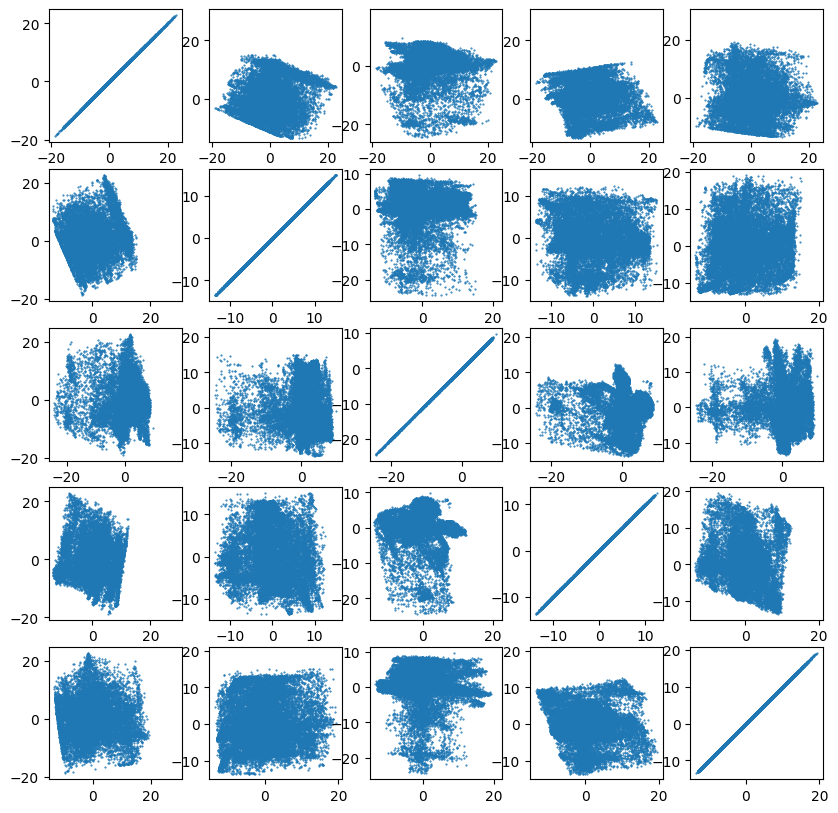

In [31]:
%matplotlib inline
# plt.plot(data[:,0], data[:,1], '.', ms=0.5)
# # plt.axis('square')
plt.figure(figsize=(10,10))
sub_shape = num_of_img
for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(data[:, i], data[:, j], '.', ms=1)
        plt.axis('square')

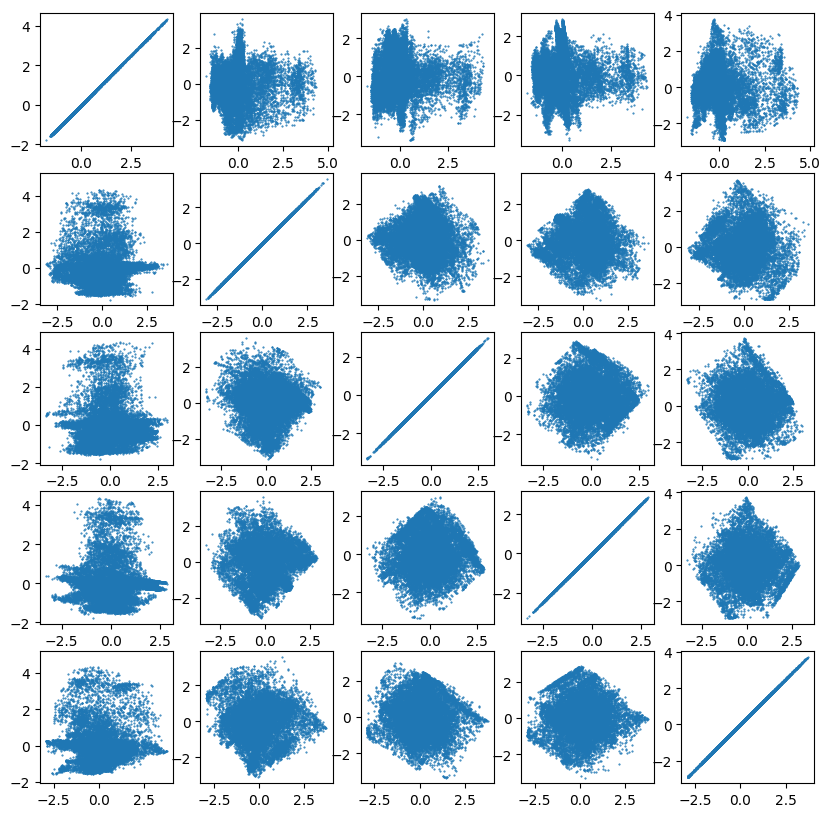

In [32]:
%matplotlib inline
# plt.plot(data[:,0], data[:,1], '.', ms=0.5)
# # plt.axis('square')
plt.figure(figsize=(10,10))
sub_shape = num_of_img
for i in range(sub_shape):
    for j in range(sub_shape):
        plt.subplot(sub_shape, sub_shape, i*sub_shape+j+1)
        plt.plot(b[i], b[j], '.', ms=1)
        plt.axis('square')

In [33]:
b.shape

(5, 16384)

In [34]:
data.shape

(16384, 5)

In [35]:
map_k_i = np.corrcoef(data.T, b)
map_k_white = np.corrcoef(data.T, x_white)
map_i_white = np.corrcoef(b, x_white)

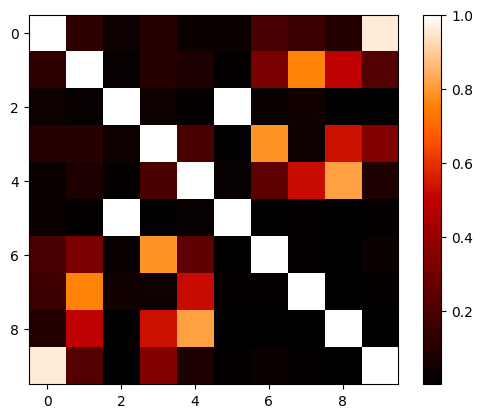

In [36]:
plt.imshow(abs(map_k_i), cmap='gist_heat')
plt.colorbar()

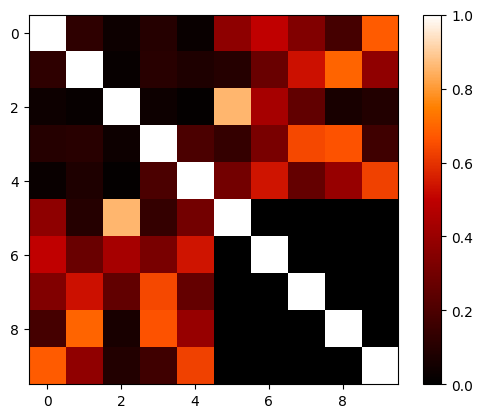

In [37]:
plt.imshow(abs(map_k_white), cmap='gist_heat')
plt.colorbar()

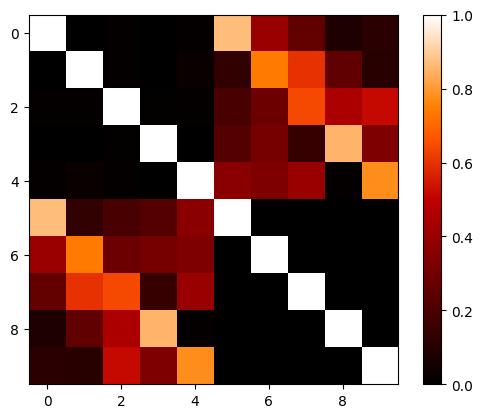

In [38]:
plt.imshow(abs(map_i_white), cmap='gist_heat')
plt.colorbar()

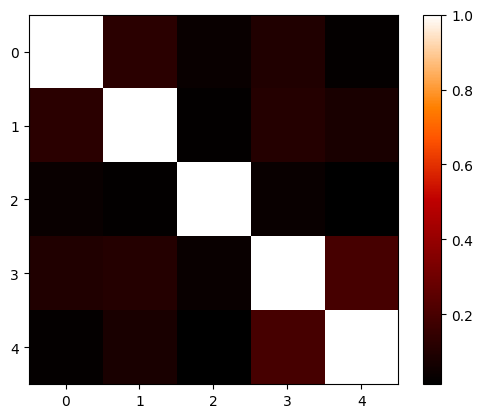

In [39]:
colormap = np.corrcoef(data.T,)

plt.imshow(abs(colormap), cmap='gist_heat')
plt.colorbar()

In [40]:
model(IPT.T)

tensor([[-1.0955, -1.1846,  0.3191,  1.0053, -1.5590],
        [-1.0694, -1.2893,  0.3287,  1.0309, -1.5669],
        [-1.1031, -1.2722,  0.2699,  1.0365, -1.5666],
        ...,
        [ 0.2691, -0.2933,  0.3408, -0.6708, -0.7269],
        [ 0.3629, -0.8184,  0.3746, -0.6427, -0.7828],
        [ 0.9361, -0.0951,  0.3464, -0.5793, -0.8242]], device='cuda:0',
       grad_fn=<NativeBatchNormBackward0>)

In [41]:
from sklearn.decomposition import FastICA

In [42]:
transformer = FastICA(n_components=num_of_img, random_state=0, whiten='unit-variance')


In [43]:
opt = transformer.fit_transform(mixture.T)

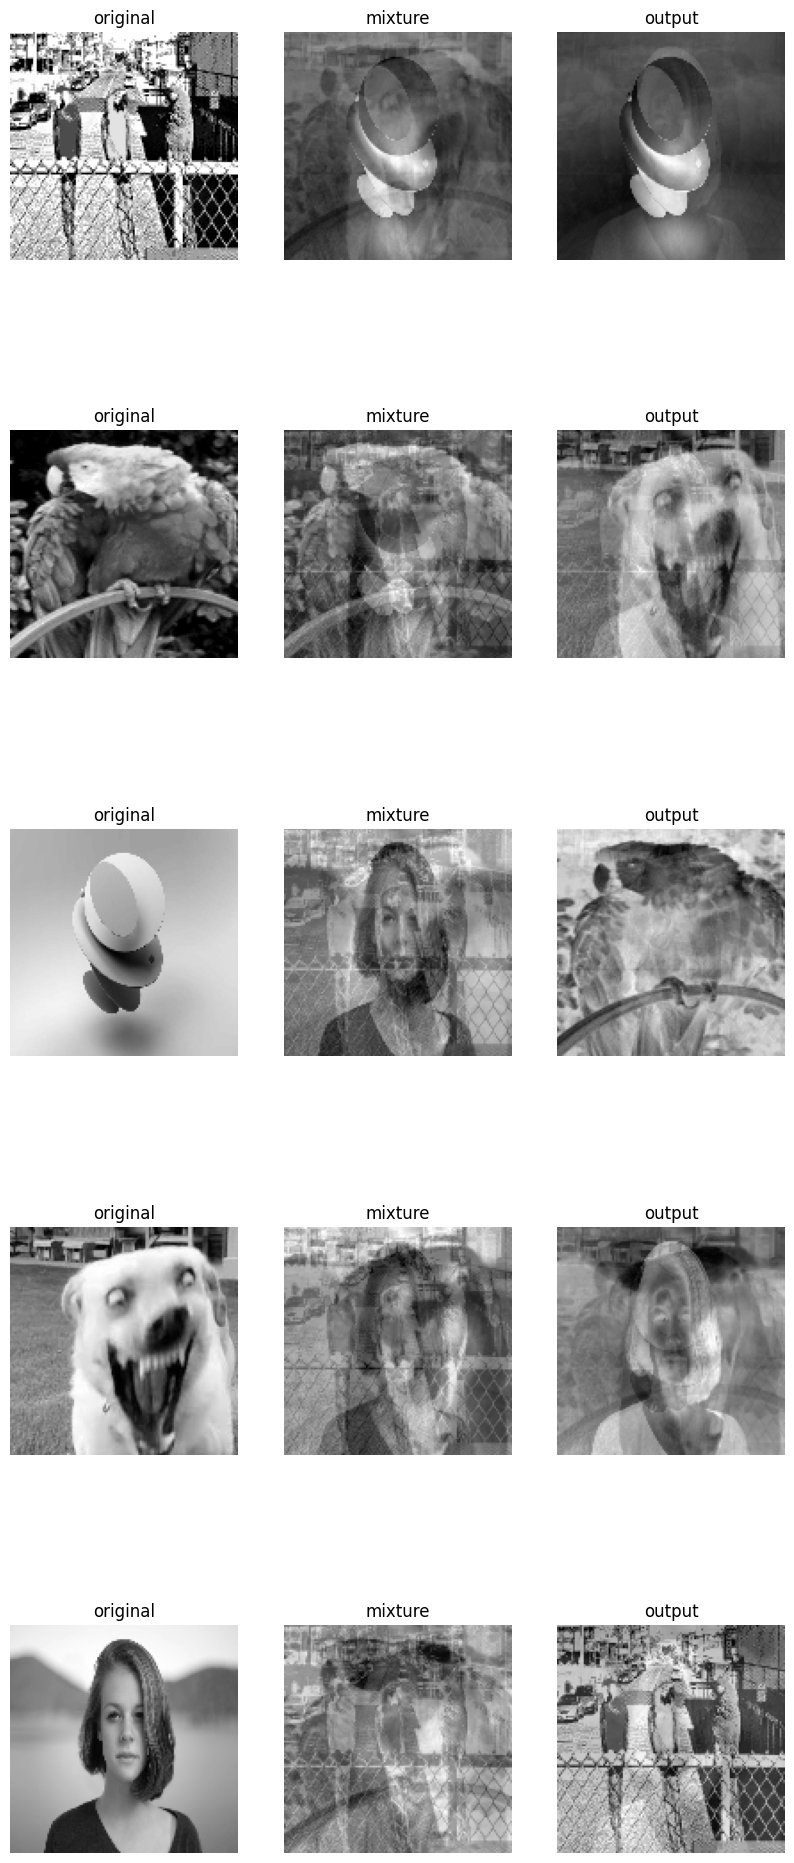

In [44]:
%matplotlib inline

plt.figure(figsize=(10,5*num_of_img))
for i in range(num_of_img):
    plt.subplot(num_of_img, 3, i*3+1)
    plt.imshow(np.reshape(array_list[i], (resize,resize)), cmap='gray')
    plt.title('original')
    plt.axis('off')
    
    plt.subplot(num_of_img, 3, i*3+2)
    plt.imshow(np.reshape(x_white[i], (resize,resize)), cmap='gray')
    plt.title('mixture')
    plt.axis('off')
    
    plt.subplot(num_of_img, 3, i*3+3)
    plt.imshow(np.reshape(opt[:, i], (resize,resize)), cmap='gray')
    plt.title('output')
    plt.axis('off')

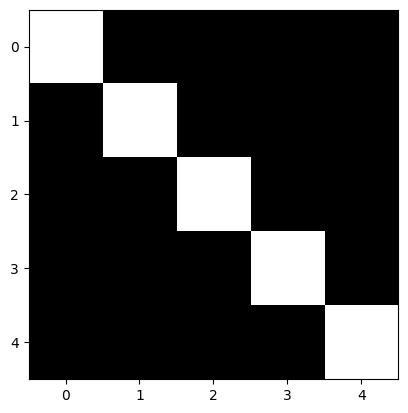

In [45]:
plt.imshow(np.corrcoef(opt.T), cmap='gist_heat')

In [46]:
np.corrcoef(opt.T)

array([[ 1.00000000e+00,  3.85867553e-16,  1.69352379e-15,
         1.21170435e-15, -1.43209554e-15],
       [ 3.85867553e-16,  1.00000000e+00, -2.57714856e-16,
        -1.05189295e-15,  1.93204827e-16],
       [ 1.69352379e-15, -2.57714856e-16,  1.00000000e+00,
        -3.83807569e-17, -4.53901240e-16],
       [ 1.21170435e-15, -1.05189295e-15, -3.83807569e-17,
         1.00000000e+00, -2.10335221e-17],
       [-1.43209554e-15,  1.93204827e-16, -4.53901240e-16,
        -2.10335221e-17,  1.00000000e+00]])

In [47]:
import torch

def compute_kurtosis(data):
    """
    Compute the kurtosis of a set of data using PyTorch.

    Args:
    data (torch.Tensor): A 1D tensor containing the data.

    Returns:
    float: The kurtosis of the data.
    """
    # Calculate the mean and standard deviation of the data
    mean = torch.mean(data)
    std = torch.std(data)

    # Calculate the fourth central moment (raw kurtosis)
    fourth_moment = torch.mean((data - mean)**4)

    # Calculate the kurtosis using the fourth central moment
    n = data.size(0)
    kurtosis = fourth_moment / (std**4) - 3.0

    return abs(kurtosis)


In [48]:
data = model.forward(IPT.T)

In [49]:
data.shape

torch.Size([16384, 5])

In [50]:
for i in range(10):
    print(compute_kurtosis(data[:,i]))

tensor(0.3400, device='cuda:0', grad_fn=<AbsBackward0>)
tensor(0.8629, device='cuda:0', grad_fn=<AbsBackward0>)
tensor(3.5135, device='cuda:0', grad_fn=<AbsBackward0>)
tensor(0.4030, device='cuda:0', grad_fn=<AbsBackward0>)
tensor(0.4554, device='cuda:0', grad_fn=<AbsBackward0>)


IndexError: index 5 is out of bounds for dimension 1 with size 5